In [1]:
import numpy as np
import pyLDAvis.gensim
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

from timeout import timeout

import comparison_funcs as cf

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
def prep_corpus(fname):
    "reads in file, makes a gensim-usable corpus out of it"

    with open(fname, 'r') as f:
        docs_full = f.readlines()

    docs = [x.split('\t')[1].split() for x in docs_full]
    for doc in docs:
        while '<NUMBER>' in doc:
            doc.remove('<NUMBER>')
        while 'patient' in doc:
            doc.remove('patient')
        while 'cell' in doc:
            doc.remove('cell')

    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return corpus, dictionary, docs


def prep_corpus_csv(fname):
    "reads in file, makes a gensim-usable corpus out of it"

    d = pd.read_csv(fname)
        
    docs = []
    for i in range(len(d.index)):
        docs.append(d.iloc[i,2].split())
    
    for doc in docs:
        while '<NUMBER>' in doc:
            doc.remove('<NUMBER>')
        while 'patient' in doc:
            doc.remove('patient')
        while 'cell' in doc:
            doc.remove('cell')

    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return corpus, dictionary, docs


In [3]:
corp, dictionary, docs = prep_corpus_csv('sampledata.csv')
corp2, dictionary2, docs2 = prep_corpus('pubmed_subset_13.tsv')


In [4]:
@timeout(30)
def make_lda_model(k, corp, dictionary, random_state=1, iterations=1, umass=[], cv=[], times=[]):
        start = time.time()
        lda_model = LdaModel(corpus = corp, id2word = dictionary, iterations = iterations, num_topics = k, random_state=random_state)
        cm1 = CoherenceModel(model = lda_model, corpus = corp, dictionary = dictionary, coherence = 'u_mass')
        cm2 = CoherenceModel(model = lda_model, texts = docs, dictionary = dictionary, coherence = 'c_v')
        with np.errstate(invalid='ignore'):
            cv_cm2 = cm2.get_coherence()
            
        umass.append(cm1.get_coherence())
        cv.append(cv_cm2)

        end = time.time()
        times.append(end - start)
        
        return umass, cv, times





def loop_through_topics(k, corp, dictionary, random_state=1, iterations=1):
    umass = []
    cv = []
    times = []

    for i in k:
        umass, cv, times = make_lda_model(i, corp, dictionary, random_state, iterations, umass, cv, times)
        print('Finished model with ' + str(i) + ' topics. Time: ' + str(times[-1]))
    
    return umass, cv, times


In [ ]:
k = list(range(40,100,10))
#k.remove(26)
#k.remove(12)
#no idea why this is happening

um, cv, times = loop_through_topics(k, corp2, dictionary2, 1,1)

In [ ]:
plt.scatter(k, um)

In [ ]:
plt.scatter(k, cv)
# creating nans, not sure why

## To Do:

- Be able to manually identify a perplexity measure and store it, along with the params for one model
- Run the second model, searching for that perplexity value
- Compare the two models using jaccard / diff

In [6]:
target_perplex = -2.1

In [7]:
k = list(range(50,100,2))
k.remove(66)
#k.remove(12)
#no idea why this is happening

rs = 1

um, cv, times = loop_through_topics(k, corp2, dictionary2, 1,rs)

outdf = pd.DataFrame(list(zip(um, cv, times)))
outdf.to_csv('tm_stats' + str(rs) + '.csv')

/opt/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)


Finished model with 50 topics. Time: 6.599323749542236
Finished model with 52 topics. Time: 6.775893926620483
Finished model with 54 topics. Time: 6.766344308853149
Finished model with 56 topics. Time: 7.39414381980896
Finished model with 58 topics. Time: 7.249446868896484
Finished model with 60 topics. Time: 7.328322172164917
Finished model with 62 topics. Time: 7.548957109451294
Finished model with 64 topics. Time: 7.682478904724121
Finished model with 68 topics. Time: 8.404802083969116
Finished model with 70 topics. Time: 8.391406059265137
Finished model with 72 topics. Time: 8.728726863861084
Finished model with 74 topics. Time: 8.832854986190796
Finished model with 76 topics. Time: 9.103187799453735
Finished model with 78 topics. Time: 9.484638214111328
Finished model with 80 topics. Time: 9.525152921676636
Finished model with 82 topics. Time: 10.020076990127563
Finished model with 84 topics. Time: 10.110887050628662
Finished model with 86 topics. Time: 10.568992853164673
Finished

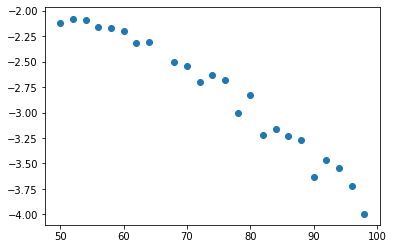

In [8]:
plt.scatter(k, um)

In [10]:
rs = 1
outdf = pd.DataFrame(list(zip(um, cv, times)))
outdf.to_csv('tm_stats' + str(rs) + '.csv')

In [41]:
m1 = LdaModel(corpus = corp2, id2word = dictionary2, iterations = 10, num_topics = 50, random_state=1)
m2 = LdaModel(corpus = corp2, id2word = dictionary2, iterations = 10, num_topics = 50, random_state=2)

In [42]:
d, a = m1.diff(m2, diagonal=False)

In [43]:
df = pd.DataFrame(d)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.701417,0.765166,0.657102,0.675514,0.679387,0.766051,0.745799,0.610800,0.613555,0.662530,...,0.772419,0.630403,0.570829,0.860488,0.593747,0.747314,0.682674,0.633199,0.547850,0.699992
1,0.663811,0.675847,0.601183,0.618496,0.593022,0.708273,0.656053,0.603516,0.563284,0.623372,...,0.775330,0.567751,0.540483,0.747962,0.566635,0.660299,0.640610,0.603197,0.574945,0.616268
2,0.665757,0.705114,0.598581,0.645701,0.626375,0.647794,0.661819,0.587592,0.574578,0.619679,...,0.722107,0.632463,0.564555,0.659668,0.581629,0.651491,0.566414,0.562268,0.543672,0.609723
3,0.612682,0.604985,0.664560,0.570491,0.564099,0.817329,0.696756,0.736591,0.621027,0.734310,...,0.634765,0.658862,0.591320,0.591862,0.647464,0.782433,0.673770,0.663378,0.584540,0.638333
4,0.534002,0.686736,0.640086,0.558793,0.600115,0.771395,0.743748,0.610530,0.491431,0.618001,...,0.650081,0.578357,0.445484,0.724792,0.516756,0.742626,0.619884,0.517958,0.397867,0.633436


In [44]:
mins = df.min(axis=1)

In [45]:
mins

0     0.491887
1     0.533653
2     0.528738
3     0.553295
4     0.384531
5     0.490522
6     0.534162
7     0.512426
8     0.584067
9     0.559412
10    0.548694
11    0.510198
12    0.532295
13    0.376438
14    0.445212
15    0.454757
16    0.563480
17    0.505894
18    0.444747
19    0.506158
20    0.508878
21    0.493005
22    0.433523
23    0.570509
24    0.540758
25    0.498530
26    0.499141
27    0.487042
28    0.551799
29    0.439440
30    0.474253
31    0.504102
32    0.462020
33    0.499480
34    0.518831
35    0.483803
36    0.446146
37    0.444906
38    0.430967
39    0.557569
40    0.452472
41    0.401423
42    0.468695
43    0.528580
44    0.504257
45    0.522232
46    0.551420
47    0.537774
48    0.471515
49    0.529940
dtype: float64